## Data Loading

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from six import string_types

from skimage import io
from skimage.transform import resize
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn import preprocessing


%matplotlib inline

In [2]:
WHALE_ROOT = os.path.abspath('../Whales/')
WHALE_TRAIN = os.path.join(WHALE_ROOT, 'train')
WHALE_TEST = os.path.join(WHALE_ROOT, 'test')

train = pd.read_csv(os.path.join(WHALE_ROOT, 'train.csv'))
train.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [3]:
train.describe()

,Image,Id
count,9850,9850
unique,9850,4251
top,5237fe9f.jpg,new_whale
freq,1,810


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 2 columns):
Image    9850 non-null object
Id       9850 non-null object
dtypes: object(2)
memory usage: 154.0+ KB


## Pre-Processing

Let's one-hot-encode the whale labels.

In [5]:
encoder=preprocessing.OneHotEncoder(sparse=False)

train_encoded = pd.DataFrame(encoder.fit_transform(train['Id'].values.reshape(-1,1)))

train_encoded.columns = encoder.get_feature_names(['Id'])

train.drop(['Id'] ,axis=1, inplace=True)

train= pd.concat([train, train_encoded ], axis=1)

In [6]:
train[train_encoded.columns].sum()

Id_new_whale    810.0
Id_w_0013924      3.0
Id_w_001ebbc      1.0
Id_w_002222a      2.0
Id_w_002b682      1.0
                ...  
Id_w_ffb4e3d      2.0
Id_w_ffbd74c      2.0
Id_w_ffcd98e      2.0
Id_w_ffda8b2      4.0
Id_w_ffdab7a      1.0
Length: 4251, dtype: float64

Let's write a couple of helper functions for loading image samples.
<br>These will not be our main load functions. They're for testing purposes only.

In [7]:
def sample_filenames(Ids, n=None):
    """Randomly sample filenames of n images with the specified Ids."""
    condition = True
    if isinstance(Ids, string_types):
        raise ValueError("Pass a list of Ids, not a single Id.")
    for Id in Ids:
        condition = condition & (train['Id_' +Id] == 1)
    
    sample = None
    if n is not None:
        sample = train[condition].sample(n)
    else:
        sample = train[condition]
    return sample['Image']

In [8]:
def load_images(filenames):
    '''Look through the directory tree to find the image you specified'''
    images = []
    for fname in filenames:
        path = os.path.abspath(os.path.join(WHALE_TRAIN, fname))
        if os.path.exists(path):
            images.append(io.imread(path))
        else:    
            print('Load failed: could not find image {}'.format(path))
    return images

Let's get an idea of what the images are like:

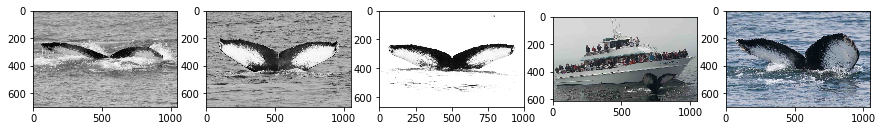

In [9]:
filenames = sample_filenames(['w_98baff9'], n=5)
bgrn_images = load_images(filenames)

fig = plt.figure()
fig.set_size_inches(15, 50)
for i, image in enumerate(bgrn_images):
    a = fig.add_subplot(1, 5, i+1)
    plt.imshow(image)
#     plt.imshow(resize(image, (480, 640)))

<p style="background-color:#E8E8E8; padding:10px">
<strong>***To Do:***</strong> One of the images has a large boat looming in the background. How does the model perform on that?
</p>

<p style="background-color:#E8E8E8; padding:10px">
<strong> *****  To Do:  ****** </strong>
<br>Pre-processing:
<br>Resize - Why? The images are not all of the same size.
<br>Convert all to grayscale - Why? Not all images are colored.
<br>Normalize - Why? Helps the model perform better.
<br>
<br>Data Augmentation:
<br>Rotate, Shear, Affine, Haze, Jitter - Why? The flukes are in different positions or orientations; are not always in the centre of the image.
<br>Vertical Crop - Why? Some images have an extra white band at the bottom or sides for license information etc.
<br>
<br>Split the data into train-test-val using Stratified Shuffle Split.


<br>https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class
</p>

Let's see what a few of the basic transformations do.
<br>Centre-Crop:

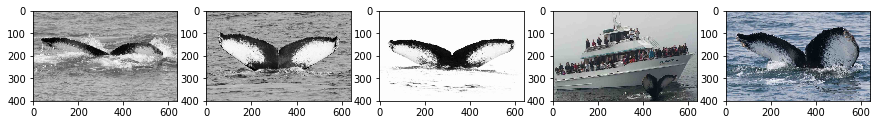

In [10]:
trfms = transforms.Compose([transforms.CenterCrop((400, 640))])

fig = plt.figure()
fig.set_size_inches(15, 50)
for i, image in enumerate(bgrn_images):
    a = fig.add_subplot(1, 5, i+1)
    resized_img = resize(image, (480, 640, 3), anti_aliasing=True)
    img_tensor = torch.Tensor(resized_img.transpose((2, 0, 1)))
    transformed_image = trfms(img_tensor)
    plt.imshow(transformed_image.permute((1, 2, 0)))

Gaussian Blur:

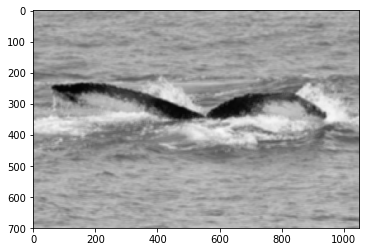

In [11]:
toTensor = transforms.ToTensor()
gaussblur = transforms.GaussianBlur((9, 9), sigma=(10, 10))

img = gaussblur(toTensor(bgrn_images[0]))
# img.shape
plt.imshow(img.permute((1,2,0)))

Affine:

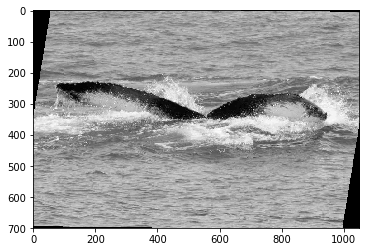

In [12]:
affine = transforms.RandomAffine(30, shear=10)
toTensor = transforms.ToTensor()
img = affine(toTensor(bgrn_images[0]))
# img.shape
plt.imshow(img.permute((1,2,0)))

Instead of centre-crop, use a vertical crop. Don't see how centre-crop could help.

So the ones below will be the final transformations we'll use on the data. It's a mix of pre-processing and data-augmentation.
<br>Notice that augmentation is not done on the test data.

In [33]:
transformations = {
    'train': transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize((480, 640)),
                            transforms.Grayscale(num_output_channels=1),
                            transforms.CenterCrop((400, 640)), # Vertical Crop
                            transforms.RandomAffine(30, shear=20), # Rotation and Shear
                            transforms.GaussianBlur((9, 9), sigma=(10, 10)),
                            transforms.RandomHorizontalFlip(p=1), # Not very random is it?
                            transforms.Resize((128, 128)),
                            transforms.ToTensor()
                       ]),
    'test': transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize((480, 640)),
                            transforms.Grayscale(num_output_channels=1),
                            transforms.CenterCrop((400, 640)),
                            transforms.Resize((128, 128)),
                            transforms.ToTensor()
                       ])
}

Next, let's write code for our custom dataset. This helps us define pre-processing steps, transformations etc all in one place.
<br>All of these are automatically applied during load, which is pretty neat.
<br>While loading data, we create an augmented copy of the original image in case of training.

In [14]:
class WhaleDataset(Dataset):
    """Whale dataset."""

    def __init__(self, csv_file, root_dir, transform=None, mode='train'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample. Creates an augmented copy of the original image and sends both.
        """

        self.whale_frame = pd.read_csv(csv_file)
        
        # OneHotEncode the whale labels
        encoder=preprocessing.OneHotEncoder(sparse=False)
        
        train_encoded = pd.DataFrame(encoder.fit_transform(self.whale_frame['Id'].values.reshape(-1,1)))
        train_encoded.columns = encoder.get_feature_names(['Id'])

        self.whale_frame.drop(['Id'] ,axis=1, inplace=True)
        self.whale_frame = pd.concat([self.whale_frame, train_encoded ], axis=1)
        
        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.whale_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.whale_frame.iloc[idx, 0])
        image = io.imread(img_name)
        whale_id = self.whale_frame.iloc[idx, 1:].values.tolist()
        whale_id_tensor = torch.Tensor(whale_id)
        
        images = [image]
        ids = [whale_id_tensor]

        if self.mode == 'train':
            images[0] = self.transform['test'](image)     # Originial image is just pre-processed
            images.append(self.transform['train'](image)) # New Augmented image
            ids.append(whale_id_tensor)
        else:
            images[0] = self.transform['test'](image)     # Originial image is just pre-processed
            
        return torch.stack(ids), torch.stack(images)

Finally, we define the data-loader that helps us load our data in batches, using the custom dataset we defined above.

In [29]:
simple_dataset = WhaleDataset(csv_file=os.path.join(WHALE_ROOT, 'train.csv'),
                                       root_dir=WHALE_TRAIN,
                                       transform=transformations)

whale_dataloader = DataLoader(simple_dataset, batch_size=100,
                        shuffle=False, num_workers=0)

## Modeling

Sample Architecture that we'll be tweaking initially:
<br>(This has been taken from the recommendation made in Stanford's CS231n course)

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs

In [16]:
# Helper layer. PyTorch also has a class that does the same.
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [17]:
label_size = train.shape[1] - 1        # No of output labels

Let's define the functions we'll use for training and checking the accuracy of our models.
<br>Note: I'm checking accuracy over the training data itself. Change it later on.

In [21]:
def train_model(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (y, x) in enumerate(whale_dataloader):
            
            if t == 10:
                break
            
            # sample_images are of shape: (N, n, C, H, W)
            # N = batch_size
            # n = (1) original image + (n-1) transformed images
            # We'll flatten them into a single list of images.
            N, n, C, H, W = x.shape
            x = x.view((N*n, C, H, W))

            N, n, m = y.shape
            y = y.view((N*n, m))

            x_var = Variable(x)
            y_var = torch.argmax(y, axis=1)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % 5 == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
 
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, (y, x) in enumerate(loader):
        if t == 10:
            break
                
        N, n, C, H, W = x.shape
        x = x.view((N*n, C, H, W))

        N, n, m = y.shape
        y = y.view((N*n, m))
        y = torch.argmax(y, axis=1)

        x_var = Variable(x)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

Let's start with the basic model:

In [30]:
basic_model = nn.Sequential(
                        nn.Conv2d(1, 32, kernel_size=7, stride=1), 
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(32),  # Spatial Batch Norm
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        Flatten(),
                        nn.Linear(5408, 1024), # affine layer
                        nn.ReLU(inplace=True),
                        nn.Linear(1024, label_size), # affine layer
                    )


loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(basic_model.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

In [31]:
train_model(basic_model, loss_fn, optimizer, num_epochs = 10)

Starting epoch 1 / 10
t = 5, loss = 12.2209
t = 10, loss = 8.4291
Starting epoch 2 / 10
t = 5, loss = 6.8082
t = 10, loss = 6.5660
Starting epoch 3 / 10
t = 5, loss = 5.0678
t = 10, loss = 5.0561
Starting epoch 4 / 10
t = 5, loss = 4.0597
t = 10, loss = 3.9075
Starting epoch 5 / 10
t = 5, loss = 3.3794
t = 10, loss = 2.8442
Starting epoch 6 / 10
t = 5, loss = 2.8043
t = 10, loss = 2.0184
Starting epoch 7 / 10
t = 5, loss = 2.0365
t = 10, loss = 1.5315
Starting epoch 8 / 10
t = 5, loss = 1.6533
t = 10, loss = 1.2126
Starting epoch 9 / 10
t = 5, loss = 1.4011
t = 10, loss = 0.9994
Starting epoch 10 / 10
t = 5, loss = 1.0176
t = 10, loss = 1.0064


In [32]:
check_accuracy(basic_model, whale_dataloader)

Got 1342 / 2000 correct (67.10)


* Let's tweak the model slightly and see what happens:

1: Decreasing filter size

In [33]:
smaller_filter_model = nn.Sequential(
                        nn.Conv2d(1, 32, kernel_size=5, stride=1), 
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(32),  # Spatial Batch Norm
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        Flatten(),
                        nn.Linear(6272, 1024), # affine layer
                        nn.ReLU(inplace=True),
                        nn.Linear(1024, label_size), # affine layer
                    )

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(smaller_filter_model.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

In [ ]:
train_model(smaller_filter_model, loss_fn, optimizer, num_epochs = 10)
check_accuracy(smaller_filter_model, whale_dataloader)

Seems sligtly better. But I don't think it actually is. Acc: (72.55)

2: Reducing # of filters.

In [39]:
decr_filters_model = nn.Sequential(
                        nn.Conv2d(1, 26, kernel_size=7, stride=1), 
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(26),  # Spatial Batch Norm
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        Flatten(),
                        nn.Linear(4394, 1024), # affine layer
                        nn.ReLU(inplace=True),
                        nn.Linear(1024, label_size), # affine layer
                    )

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(decr_filters_model.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

In [40]:
train_model(decr_filters_model, loss_fn, optimizer, num_epochs = 10)
check_accuracy(decr_filters_model, whale_dataloader)

Starting epoch 1 / 10
t = 5, loss = 8.8326
t = 10, loss = 8.3279
Starting epoch 2 / 10
t = 5, loss = 6.6169
t = 10, loss = 6.5817
Starting epoch 3 / 10
t = 5, loss = 5.1711
t = 10, loss = 5.2768
Starting epoch 4 / 10
t = 5, loss = 3.7842
t = 10, loss = 4.0094
Starting epoch 5 / 10
t = 5, loss = 2.9006
t = 10, loss = 2.8523
Starting epoch 6 / 10
t = 5, loss = 2.2677
t = 10, loss = 2.1449
Starting epoch 7 / 10
t = 5, loss = 1.7855
t = 10, loss = 1.5069
Starting epoch 8 / 10
t = 5, loss = 1.4899
t = 10, loss = 1.1215
Starting epoch 9 / 10
t = 5, loss = 1.0790
t = 10, loss = 1.0592
Starting epoch 10 / 10
t = 5, loss = 0.9508
t = 10, loss = 0.7793
Got 1506 / 2000 correct (75.30)


Better still! Acc: (75.30)

3: Increasing # of filters.

In [41]:
incr_filters_model = nn.Sequential(
                        nn.Conv2d(1, 38, kernel_size=7, stride=1), 
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(38),  # Spatial Batch Norm
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        Flatten(),
                        nn.Linear(6422, 1024), # affine layer
                        nn.ReLU(inplace=True),
                        nn.Linear(1024, label_size), # affine layer
                    )

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(incr_filters_model.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

In [42]:
train_model(incr_filters_model, loss_fn, optimizer, num_epochs = 10)
check_accuracy(incr_filters_model, whale_dataloader)

Starting epoch 1 / 10
t = 5, loss = 10.2031
t = 10, loss = 8.3637
Starting epoch 2 / 10
t = 5, loss = 6.7228
t = 10, loss = 6.6468
Starting epoch 3 / 10
t = 5, loss = 5.0290
t = 10, loss = 5.0877
Starting epoch 4 / 10
t = 5, loss = 3.8618
t = 10, loss = 4.0127
Starting epoch 5 / 10
t = 5, loss = 2.8978
t = 10, loss = 2.9420
Starting epoch 6 / 10
t = 5, loss = 2.2560
t = 10, loss = 1.9864
Starting epoch 7 / 10
t = 5, loss = 1.7390
t = 10, loss = 1.3957
Starting epoch 8 / 10
t = 5, loss = 1.4519
t = 10, loss = 1.2783
Starting epoch 9 / 10
t = 5, loss = 1.1808
t = 10, loss = 0.8134
Starting epoch 10 / 10
t = 5, loss = 1.0291
t = 10, loss = 0.8387
Got 1473 / 2000 correct (73.65)


Not bad. Acc: (73.65)

4: Reducing filter size and # of filters

In [16]:
decr_smaller_model = nn.Sequential(
                        nn.Conv2d(1, 26, kernel_size=5, stride=1), 
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(26),  # Spatial Batch Norm
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        Flatten(),          # see above for explanation
                        nn.Linear(5096, 1024), # affine layer
                        nn.ReLU(inplace=True),
                        nn.Linear(1024, label_size), # affine layer
                    )

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(decr_smaller_model.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

In [17]:
train_model(decr_smaller_model, loss_fn, optimizer, num_epochs = 20)
check_accuracy(decr_smaller_model, whale_dataloader)

Starting epoch 1 / 20
t = 5, loss = 9.0359
t = 10, loss = 8.3387
Starting epoch 2 / 20
t = 5, loss = 6.8160
t = 10, loss = 6.5961
Starting epoch 3 / 20
t = 5, loss = 5.4315
t = 10, loss = 5.2027
Starting epoch 4 / 20
t = 5, loss = 3.8557
t = 10, loss = 4.0351
Starting epoch 5 / 20
t = 5, loss = 2.9794
t = 10, loss = 3.0203
Starting epoch 6 / 20
t = 5, loss = 2.3506
t = 10, loss = 2.3258
Starting epoch 7 / 20
t = 5, loss = 1.8831
t = 10, loss = 1.7757
Starting epoch 8 / 20
t = 5, loss = 1.6820
t = 10, loss = 1.2436
Starting epoch 9 / 20
t = 5, loss = 1.1893
t = 10, loss = 1.0680
Starting epoch 10 / 20
t = 5, loss = 0.9622
t = 10, loss = 0.9410
Starting epoch 11 / 20
t = 5, loss = 0.7576
t = 10, loss = 0.7182
Starting epoch 12 / 20
t = 5, loss = 0.6567
t = 10, loss = 0.5428
Starting epoch 13 / 20
t = 5, loss = 0.6193
t = 10, loss = 0.6072
Starting epoch 14 / 20
t = 5, loss = 0.5937
t = 10, loss = 0.5015
Starting epoch 15 / 20
t = 5, loss = 0.4743
t = 10, loss = 0.4924
Starting epoch 16 /

Works well. Based on efficiency, this might be the best one due to fewer parameters. Acc: (76.40)

5: Further reducing filter size, and # of filters.

In [18]:
decr_much_smaller_model = nn.Sequential(
                        nn.Conv2d(1, 26, kernel_size=3, stride=1), 
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(26),  # Spatial Batch Norm
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        Flatten(),          # see above for explanation
                        nn.Linear(5850, 1024), # affine layer
                        nn.ReLU(inplace=True),
                        nn.Linear(1024, label_size), # affine layer
                    )

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(decr_much_smaller_model.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

In [19]:
train_model(decr_much_smaller_model, loss_fn, optimizer, num_epochs = 10)
check_accuracy(decr_much_smaller_model, whale_dataloader)

Starting epoch 1 / 10
t = 5, loss = 8.6467
t = 10, loss = 8.2898
Starting epoch 2 / 10
t = 5, loss = 6.8485
t = 10, loss = 6.7472
Starting epoch 3 / 10
t = 5, loss = 5.2208
t = 10, loss = 5.5825
Starting epoch 4 / 10
t = 5, loss = 4.1386
t = 10, loss = 4.5639
Starting epoch 5 / 10
t = 5, loss = 3.3587
t = 10, loss = 3.4937
Starting epoch 6 / 10
t = 5, loss = 2.6995
t = 10, loss = 2.6466
Starting epoch 7 / 10
t = 5, loss = 2.1944
t = 10, loss = 1.9946
Starting epoch 8 / 10
t = 5, loss = 1.7786
t = 10, loss = 1.4911
Starting epoch 9 / 10
t = 5, loss = 1.2914
t = 10, loss = 1.2112
Starting epoch 10 / 10
t = 5, loss = 1.2790
t = 10, loss = 1.0663
Got 1311 / 2000 correct (65.55)


Reducing the Kernel size all the way down to 3 certainly hurt the model. It's probably not able to recognize any patterns like edges, corners etc. Acc: (57.65)

Write code for neural networks with dynamic layers. Use nn.ModuleList
<br>https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html

In [ ]:
class ConvReluPool(nn.Module):
    def __init__(self,  layer_params, inp_channels, input_dim, label_size):
        '''
        Take parameters for each layer and build a network with the following architecture:
        [conv-relu-pool]xN -> [affine]x2
        
        Arguments:
        layer_params: A list of tuples, each of the format (# of filters, kernel_size, stride).
        inp_channels: No of Input Channels.
        input_dim: Dimension of input image. (Assuming sqaure image per channel)
        label_size: No of labels to output.
        '''
        
        super(ConvReluPool, self).__init__()
        
        network_layers = []
        output_dim = input_dim
        output_size = None
        input_channels = inp_channels
        
        for filters, kernel_size, stride in layer_params:
            network_layers.append(nn.Conv2d(input_channels, filters, kernel_size=kernel_size, stride=stride))
            network_layers.append(nn.ReLU(inplace=True))
            network_layers.append(nn.BatchNorm2d(filters))
            network_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
            input_channels = filters                              # No of channels outputted is current filter size.
            output_dim = (output_dim - kernel_size) // stride + 1 # Due to convolution
            output_dim = (output_dim - 2) // 2 + 1                # Due to Max Pooling
            output_size = filters * output_dim * output_dim       # Final Activation Size
                
        
        network_layers.append(Flatten())
        network_layers.append(nn.Linear(output_size, 1024))
        network_layers.append(nn.ReLU(inplace=True))
        network_layers.append(nn.Linear(1024, label_size))
        
        self.network = nn.ModuleList(network_layers)

    def forward(self, x):
        # ModuleList can act as an iterable, or be indexed using ints
        for layer in self.network:
            x = layer(x)
        return x

In [124]:
two_conv_model = ConvReluPool([(26,7,1), (20,5,1)], 1, 64, label_size)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(two_conv_model.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

In [125]:
train_model(two_conv_model, loss_fn, optimizer, num_epochs = 20)
check_accuracy(two_conv_model, whale_dataloader)

Starting epoch 1 / 20
t = 5, loss = 12.6883
t = 10, loss = 8.8684
Starting epoch 2 / 20
t = 5, loss = 7.7115
t = 10, loss = 8.1011
Starting epoch 3 / 20
t = 5, loss = 5.6648
t = 10, loss = 5.4298
Starting epoch 4 / 20
t = 5, loss = 4.4680
t = 10, loss = 4.0092
Starting epoch 5 / 20
t = 5, loss = 3.6632
t = 10, loss = 3.0167
Starting epoch 6 / 20
t = 5, loss = 2.8874
t = 10, loss = 2.4266
Starting epoch 7 / 20
t = 5, loss = 2.2938
t = 10, loss = 1.9871
Starting epoch 8 / 20
t = 5, loss = 1.8841
t = 10, loss = 1.5168
Starting epoch 9 / 20
t = 5, loss = 1.4048
t = 10, loss = 1.1326
Starting epoch 10 / 20
t = 5, loss = 1.0009
t = 10, loss = 0.9380
Starting epoch 11 / 20
t = 5, loss = 0.8998
t = 10, loss = 0.8466
Starting epoch 12 / 20
t = 5, loss = 0.7472
t = 10, loss = 0.7014
Starting epoch 13 / 20
t = 5, loss = 0.6514
t = 10, loss = 0.5998
Starting epoch 14 / 20
t = 5, loss = 0.5350
t = 10, loss = 0.6108
Starting epoch 15 / 20
t = 5, loss = 0.4936
t = 10, loss = 0.4580
Starting epoch 16 

Pretty Bad. Acc: (45.10). But it's converging slowly. Maybe needs more epochs and a different optimizer.
* Removing BatchNorm makes it insanely bad! The loss never converges. Acc: (8.50) 

In [22]:
class BatchNormReluConv(nn.Module):
    def __init__(self,  layer_params, inp_channels, input_dim, label_size):
        '''
        Take parameters for each layer and build a network with the following architecture:
        [batchnorm-relu-conv]xN -> [affine]x2
        
        Arguments:
        layer_params: A list of tuples, each of the format (# of filters, kernel_size, stride).
        inp_channels: No of Input Channels.
        input_dim: Dimension of input image. (Assuming sqaure image per channel)
        label_size: No of labels to output.
        '''
        
        super(BatchNormReluConv, self).__init__()
        
        network_layers = []
        output_dim = input_dim
        output_size = None
        input_channels = inp_channels
        
        for filters, kernel_size, stride in layer_params:
            network_layers.append(nn.BatchNorm2d(input_channels))
            network_layers.append(nn.ReLU(inplace=True))
            network_layers.append(nn.Conv2d(input_channels, filters, kernel_size=kernel_size, stride=stride))
            
            input_channels = filters                              # No of channels outputted is current filter size.
            output_dim = (output_dim - kernel_size) // stride + 1 # Due to convolution
            output_size = filters * output_dim * output_dim       # Final Activation Size
                   
        
        network_layers.append(Flatten())
        network_layers.append(nn.Linear(output_size, 1024))
        network_layers.append(nn.ReLU(inplace=True))
        network_layers.append(nn.Linear(1024, label_size))
        
        self.network = nn.ModuleList(network_layers)

    def forward(self, x):
        # ModuleList can act as an iterable, or be indexed using ints
        for layer in self.network:
            x = layer(x)
        return x

In [128]:
two_batchreluconv_model = BatchNormReluConv([(26,7,1), (20,5,1)], 1, 64, label_size)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(two_batchreluconv_model.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

In [129]:
train_model(two_batchreluconv_model, loss_fn, optimizer, num_epochs = 20)
check_accuracy(two_batchreluconv_model, whale_dataloader)

Starting epoch 1 / 20
t = 5, loss = 659.9511
t = 10, loss = 46.0566
Starting epoch 2 / 20
t = 5, loss = 8.3517
t = 10, loss = 8.2277
Starting epoch 3 / 20
t = 5, loss = 8.2765
t = 10, loss = 8.4587
Starting epoch 4 / 20
t = 5, loss = 12.9493
t = 10, loss = 8.0294
Starting epoch 5 / 20
t = 5, loss = 7.1981
t = 10, loss = 8.1988
Starting epoch 6 / 20
t = 5, loss = 8.0167
t = 10, loss = 7.5149
Starting epoch 7 / 20
t = 5, loss = 7.4733
t = 10, loss = 7.7647
Starting epoch 8 / 20
t = 5, loss = 7.2611
t = 10, loss = 7.5285
Starting epoch 9 / 20
t = 5, loss = 7.0848
t = 10, loss = 7.0426
Starting epoch 10 / 20
t = 5, loss = 7.1578
t = 10, loss = 7.0744
Starting epoch 11 / 20
t = 5, loss = 7.3659
t = 10, loss = 6.8798
Starting epoch 12 / 20
t = 5, loss = 7.0304
t = 10, loss = 6.7490
Starting epoch 13 / 20
t = 5, loss = 6.7739
t = 10, loss = 6.7104
Starting epoch 14 / 20
t = 5, loss = 6.7243
t = 10, loss = 6.6556
Starting epoch 15 / 20
t = 5, loss = 6.7345
t = 10, loss = 6.6179
Starting epoch 

Worst model so far! Acc: (0.30)

----

* Check output of the first Conv layer.
* Deeper models seem to be performing much worse. Adding just one layer drops accuracy significantly.
* This might be due to vanishing gradients. Can I visualize/verify this?
* Maybe ResNets will handle this better?
* BatchNorm seems to be important. Probably because the model needs to generalize well, given the large number of labels.

Let's create a helper method for visualizing any image tensor.

In [22]:
def visTensor(tensor, ch=0, allkernels=False, nrow=6, padding=1):
    '''
    Visualizes a tensor by plotting each dimension as a separate image in a grid.
    '''
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

The following function prints: 
* original image
* output of the first conv layer.
* The filters of the first conv layer. It prints each of them seperately in a grid fashion.

In [34]:
def plotFltrOutputs(conv_layer):
    for t, (y, x) in enumerate(whale_dataloader):
        
        if t == 1: # Basically sampling only 1 batch of data
            break

        # sample_images are of shape: (N, n, C, H, W)
        # N = batch_size
        # n = (1) original image + (n-1) transformed images
        # We'll flatten them into a single list of images.
        N, n, C, H, W = x.shape
        x = x.view((N*n, C, H, W))

        img_tensor = x[0].view((1, 1, H, W))
        visTensor(img_tensor, ch=0, allkernels=False) # Original Image
        output = conv_layer(img_tensor)
        visTensor(output, ch=0, allkernels=False) # Conv layer output
        C, N, H, W = output.shape
        output = output.view((N, C, H, W))
        visTensor(output, ch=0, allkernels=False) # Each dimension of filter

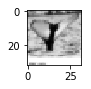

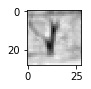

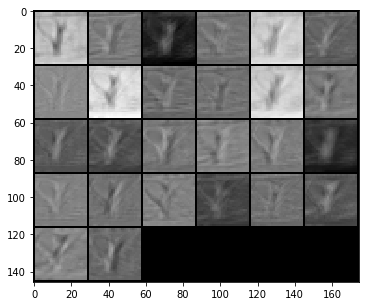

In [19]:
plotFltrOutputs(decr_smaller_model[0])

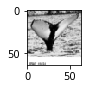

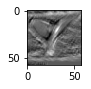

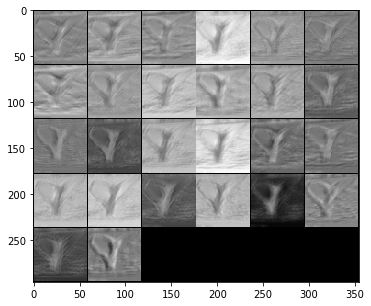

In [155]:
plotFltrOutputs(two_conv_model.network[0])

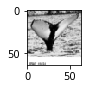

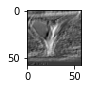

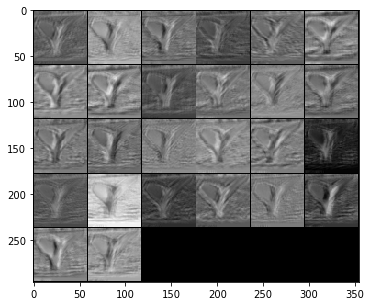

In [158]:
plotFltrOutputs(two_batchreluconv_model.network[2])

--------

* Visualized filters
* Visualized filter outputs
* Check gradient visualization

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.100e+01,
        2.400e+01, 4.207e+03, 5.000e+00, 2.000e+00]),
 array([-0.00946132, -0.0081451 , -0.00682887, -0.00551265, -0.00419643,
        -0.00288021, -0.00156399, -0.00024776,  0.00106846,  0.00238468,
         0.0037009 ], dtype=float32),
 <a list of 10 Patch objects>)

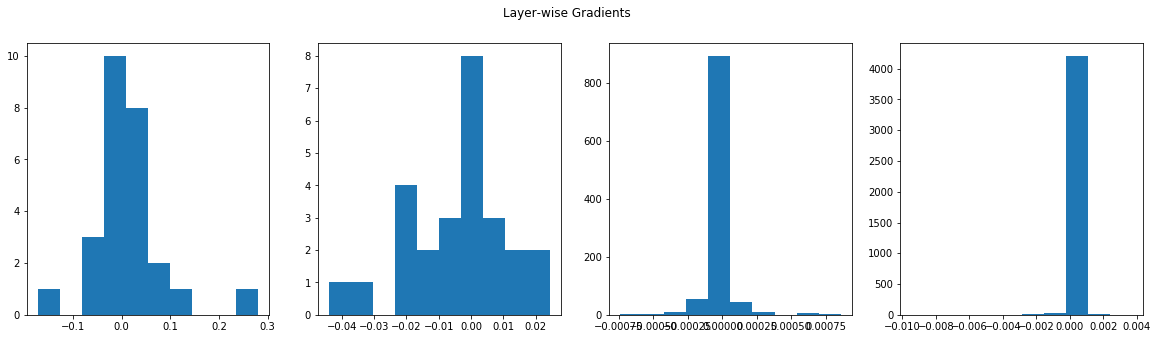

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
fig.suptitle('Layer-wise Gradients')

g = decr_smaller_model[0].weight.grad
N, C, H, W = g.shape
g = g.view((N, C*H*W))
means = torch.mean(g, axis=1)
ax1.hist(means)

g = decr_smaller_model[2].weight.grad
ax2.hist(g)

g = decr_smaller_model[5].weight.grad
means = torch.mean(g, axis=1)
ax3.hist(means)

g = decr_smaller_model[7].weight.grad
means = torch.mean(g, axis=1)
ax4.hist(means)

Not a great job. Let's get back to this.

* https://www.fast.ai/2020/01/13/self_supervised/
* http://karpathy.github.io/2019/04/25/recipe/

Let's define a ResNet and see how that does. I'm hoping it'll give a better gradient flow.
<br>I think that's important considering the number of labels we're expected to predict.

In [35]:
class ResBlock(nn.Module):
    '''
    Implements the Residual Block that is repeated across the ResNet architecture.
    X -> Conv -> Batch Norm -> Relu -> Conv -> Batch Norm -> ^ -> Relu
    |-->---->---->--->--->---->---->--->---->--->--->--->--->|
    The input is added after the second Batch Norm layer. This gives better gradient flow.
    '''
    def __init__(self, input_dim, num_filters, stride=1, downsample=None, group='group', number=0):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_dim, num_filters, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(num_filters)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(num_filters)
        self.downsample = downsample
        self.group = group
        self.number = number
        
    
    def forward(self, x):
        _input = x
        
        out= self.conv1(x)
        out = self.bnorm1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bnorm2(out)
        
        if self.downsample != None:
            _input = self.downsample(x)
        
#         print(self.group + ' - ' + str(self.number))
#         print(out.shape, _input.shape, self.downsample == None)
        out += _input
        
        return self.relu(out)

In [36]:
class ResNet(nn.Module):
    '''
    Puts the ResNet together based on the information provided:
    block: basic block being used.
    groups: list of integers indicating the number of resnet blocks in each group.
    num_classes: No of classes to output.
    '''
    def __init__(self, block, groups, num_classes):
        super().__init__()
        
        self.inp_dims = 64
        self.conv = nn.Conv2d(1, self.inp_dims, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bnorm = nn.BatchNorm2d(self.inp_dims)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.group1 = self.group_helper(block, 64, groups[0], group='group1')
        self.group2 = self.group_helper(block, 128, groups[1], stride=2, group='group2')
        self.group3 = self.group_helper(block, 256, groups[2], stride=2, group='group3')
        self.group4 = self.group_helper(block, 512, groups[3], stride=2, group='group4')

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)
    
    
    def group_helper(self, block, num_filters, num_blocks, stride=1, group='group'):
    
        downsample = None
        if stride != 1 or self.inp_dims != num_filters:
            # Downsample re-sizes the input so that it matches with the conv-relu-conv output,
            # to which it added in the ResNet block.
            downsample = nn.Sequential(nn.Conv2d(self.inp_dims, num_filters, kernel_size=1,
                                                 stride=stride, bias=False),
                                       nn.BatchNorm2d(num_filters)
                                      )
        layers = []
        layers.append(block(self.inp_dims, num_filters, stride, downsample, group=group, number=1))

        self.inp_dims = num_filters
        for _ in range(1, num_blocks):
            layers.append(block(num_filters, num_filters, group=group, number=(_+1)))

        return nn.Sequential(*layers)

    
    def forward(self, x):
        
        out = self.conv(x)
        out = self.bnorm(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.group1(out)
        out = self.group2(out)
        out = self.group3(out)
        out = self.group4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [18]:
def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(ResBlock, layers, label_size)
    return model

def resnet10():
    layers=[1, 1, 1, 1]
    model = ResNet(ResBlock, layers, label_size)
    return model

In [35]:
resnet10 = resnet10()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(resnet10.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

train_model(resnet10, loss_fn, optimizer, num_epochs = 10)
check_accuracy(resnet10, whale_dataloader)

Starting epoch 1 / 10
t = 5, loss = 8.5421
t = 10, loss = 8.1844
Starting epoch 2 / 10
t = 5, loss = 7.0002
t = 10, loss = 7.3781
Starting epoch 3 / 10
t = 5, loss = 6.6242
t = 10, loss = 6.9074
Starting epoch 4 / 10
t = 5, loss = 6.0248
t = 10, loss = 6.5287
Starting epoch 5 / 10
t = 5, loss = 5.6460
t = 10, loss = 6.3011
Starting epoch 6 / 10
t = 5, loss = 5.3816
t = 10, loss = 5.7812
Starting epoch 7 / 10
t = 5, loss = 5.2465
t = 10, loss = 5.4246
Starting epoch 8 / 10
t = 5, loss = 5.0701
t = 10, loss = 5.1777
Starting epoch 9 / 10
t = 5, loss = 4.8580
t = 10, loss = 4.8380
Starting epoch 10 / 10
t = 5, loss = 5.4165
t = 10, loss = 4.7141
Got 148 / 2000 correct (7.40)


Seems pretty bad. I think we already established that deeper models aren't doing that well. Probably because of a lack in training data.
<br>Acc: (7.40)

In [19]:
RESNET10_PATH = os.path.join(WHALE_ROOT, 'resnet10.pt')

# Save
# torch.save(resnet10, RESNET10_PATH)

# Load
model = torch.load(RESNET10_PATH)
# model.eval()

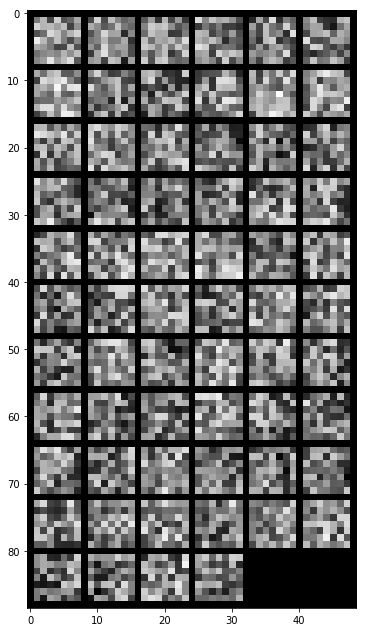

In [27]:
filters = model.conv.weight
visTensor(filters, ch=0, allkernels=False)

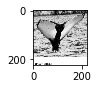

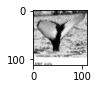

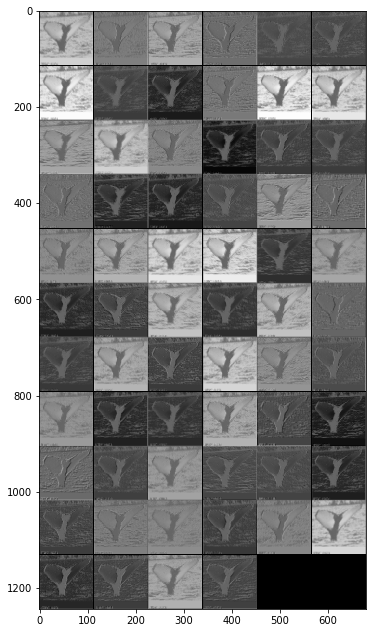

In [28]:
plotFltrOutputs(model.conv)

The model doesn't seem to be doing anything. The original and transformed image are almost the same!

---
Let's use the same concept of skip connections though, and design a mini resnet.

In [38]:
class MiniResNet(nn.Module):
    '''
    Puts the ResNet together based on the information provided:
    block: basic block being used.
    groups: list of integers indicating the number of resnet blocks in each group.
    num_classes: No of classes to output.
    '''
    def __init__(self, block, num_classes):
        super().__init__()
        
        self.inp_dims = 26
        self.conv = nn.Conv2d(1, self.inp_dims, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bnorm = nn.BatchNorm2d(self.inp_dims)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.resnet_layer = self.layer_helper(block, 26)
        
        self.avgpool = nn.AdaptiveAvgPool2d((13, 13))
        self.fc = nn.Linear(4394, num_classes)
    
    
    def layer_helper(self, block, num_filters, stride=1):
    
        downsample = None
        if stride != 1 or self.inp_dims != num_filters:
            # Downsample re-sizes the input so that it matches with the conv-relu-conv output,
            # to which it is added in the ResNet block.
            downsample = nn.Sequential(nn.Conv2d(self.inp_dims, num_filters, kernel_size=1,
                                                 stride=stride, bias=False),
                                       nn.BatchNorm2d(num_filters)
                                      )
        layer = block(self.inp_dims, num_filters, stride, downsample)

        return layer

    
    def forward(self, x):
        
        out = self.conv(x)
        out = self.bnorm(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.resnet_layer(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [63]:
mini_resnet = MiniResNet(ResBlock, label_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mini_resnet.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

# optimizer = optim.RMSprop(mini_resnet.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

train_model(mini_resnet, loss_fn, optimizer, num_epochs = 20)
check_accuracy(mini_resnet, whale_dataloader)

Starting epoch 1 / 20
t = 5, loss = 14.2082
t = 10, loss = 13.9179
Starting epoch 2 / 20
t = 5, loss = 6.2663
t = 10, loss = 6.5220
Starting epoch 3 / 20
t = 5, loss = 6.2092
t = 10, loss = 6.1327
Starting epoch 4 / 20
t = 5, loss = 4.2839
t = 10, loss = 4.5605
Starting epoch 5 / 20
t = 5, loss = 3.9588
t = 10, loss = 2.9686
Starting epoch 6 / 20
t = 5, loss = 2.7831
t = 10, loss = 2.5567
Starting epoch 7 / 20
t = 5, loss = 2.2969
t = 10, loss = 1.6519
Starting epoch 8 / 20
t = 5, loss = 1.6040
t = 10, loss = 1.4542
Starting epoch 9 / 20
t = 5, loss = 1.2865
t = 10, loss = 1.1028
Starting epoch 10 / 20
t = 5, loss = 1.0297
t = 10, loss = 1.0502
Starting epoch 11 / 20
t = 5, loss = 1.0338
t = 10, loss = 0.9196
Starting epoch 12 / 20
t = 5, loss = 0.7977
t = 10, loss = 0.6638
Starting epoch 13 / 20
t = 5, loss = 0.7144
t = 10, loss = 0.8238
Starting epoch 14 / 20
t = 5, loss = 0.5803
t = 10, loss = 0.4520
Starting epoch 15 / 20
t = 5, loss = 0.5401
t = 10, loss = 0.4460
Starting epoch 16

In [20]:
MINIRESNET_PATH = os.path.join(WHALE_ROOT, 'mini_resnet.pt')

# Save
# torch.save(mini_resnet, MINIRESNET_PATH)

# Load
# mini_resnet = torch.load(MINIRESNET_PATH)
# model.eval()

* Change the input size to 128x128
* Then apply AdaptiveAvgPool

What works:
* Input-size: 64x64
* AdaptiveAvgPool2d((13, 13))
* Acc: 71.95%

Little Better:
* Input-size: 128x128
* AdaptiveAvgPool2d((13, 13))
* Acc: 79.70
* *
* optim.Adam(mini_resnet.parameters(), lr=1e-2)
* Acc: (89.10)
* *
* The optimization is causing the loss to jump quickly, so I've reduced the learning rate.
* optim.Adam(mini_resnet.parameters(), lr=1e-3)
* Acc: (93.65)

* *
* Same as before, with smaller # of filters: 26
* Acc: (94.15)

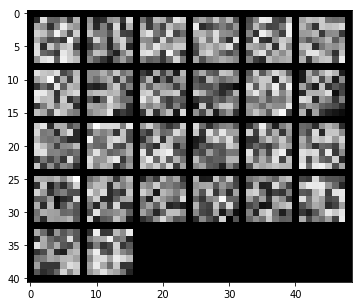

In [24]:
filters = mini_resnet.conv.weight
visTensor(filters, ch=0, allkernels=False)

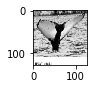

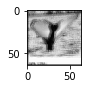

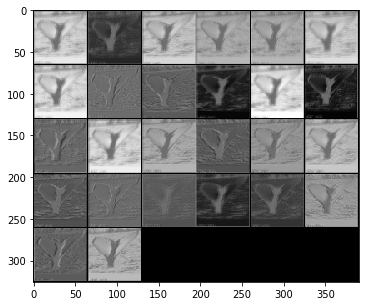

In [25]:
plotFltrOutputs(mini_resnet.conv)

What does Adaptive Avg Pooling do?
* https://discuss.pytorch.org/t/what-is-adaptiveavgpool2d/26897
<br>Why does it work for ResNets?
* https://stackoverflow.com/questions/58689997/why-does-the-global-average-pooling-work-in-resnet
<br>It's actually Global Average Pooling
* https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/

---
On a side-note, the Accuracies mentioned above are after 20 epochs, as compared to only 10 epochs for the earlier models.
<br>But this is still the best model according to me.
<br>As you'll see next in the saliency maps, it seems to generalize well.

In [122]:
def compute_saliency_maps(X_var, y_var, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 1, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained network that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    # Forward pass.
    scores = model(X_var)
    
    # Gathering correct class scores
    scores = scores.gather(1, y_var.view(-1, 1)).squeeze()  
    
    # Backward pass, need to supply initial gradients of same tensor shape as scores.
    scores.backward(torch.FloatTensor([1.0] * scores.shape[0]))
    
    # Get gradient for image.
    img_grad = X_var.grad.data
    
    # Converting from 3d to 1d.
    saliency, i = torch.max(img_grad.abs(),dim=1)

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

Let's create a mini dataloader for visualizing purposes.

In [123]:
mini_dataloader = DataLoader(simple_dataset, batch_size=2,
                        shuffle=True, num_workers=0)

In [132]:
def show_saliency_maps(model):
    
    X = None
    y = None
    X_var = None
    y_var = None
    for (y_batch, X_batch) in mini_dataloader:

        N, n, C, H, W = X_batch.shape
        X = X_batch.view((N*n, C, H, W))

        N, n, m = y_batch.shape
        y = y_batch.view((N*n, m))

        X_var = Variable(X, requires_grad=True)
        y_var = torch.argmax(y, axis=1)

        break

    # Compute saliency maps for images in sample_x_var
    saliency = compute_saliency_maps(X_var, y_var, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        image = X[i,:,:,:]
        C, H, W = image.shape
        image = image.view((C*H, W))
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

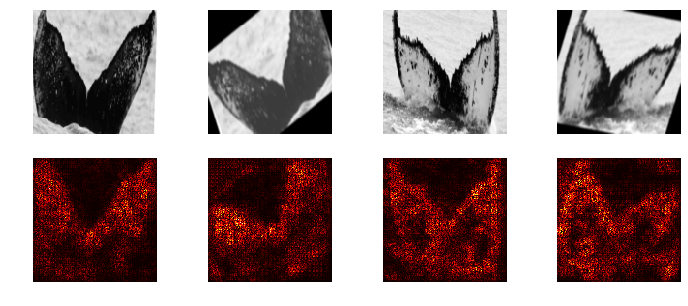

In [133]:
show_saliency_maps(mini_resnet)

Observations:
* Lots of noise in the gradient, which is understandle considering the large of output classes. I think this helps it generalize well. Does it?
* The model is focusing on the darker areas of the fin, which makes sense, because that determines the outline and shape of the fin.
* When the image is rotated, so is the gradient map. Meaning, it's adjusting well to different fin orientations.
* The white bar at the bottom with text, if any, doesn't seem to influence the classification, which is good.

Drawbacks:
* Some images are not properly classified. Makes sense, accuracy is not a 100%.
* For some images, everything except for the fin region is getting activated. Why?